In [ ]:
%matplotlib inline
%cd ODML-Swin-Transfomer
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import softmax
import torch

def svd(m):
    return np.linalg.svd(m, compute_uv=False)

: 

In [2]:
import argparse
from logger import create_logger
import os


from utils import load_checkpoint, load_pretrained
from config import get_config
from data import build_loader
from models import build_model

from config import get_only_config
import json

/afs/andrew.cmu.edu/usr8/bmarimut/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Warning] Fused window process have not been installed. Please refer to get_started.md for installation.
Tutel has not been installed. To use Swin-MoE, please install Tutel; otherwise, just ignore this.


In [3]:
# f = open('config_export.json')
# config = json.load(f)

In [4]:
config_path = 'configs/swin/swin_tiny_patch4_window7_224_resisc45.yaml'
config = get_only_config(config_path)

=> merge config from configs/swin/swin_tiny_patch4_window7_224_resisc45.yaml


In [5]:
config.defrost()
config.OUTPUT = "/afs/ece.cmu.edu/usr/bmarimut/Private/output"
config.MODEL.PRETRAINED = "/afs/ece.cmu.edu/usr/ashwinve/Public/ckpt_epoch_29_6.pth"
config.freeze()
os.makedirs(config.OUTPUT, exist_ok=True)
logger = create_logger(output_dir=config.OUTPUT, name=f"{config.MODEL.NAME}")


In [ ]:
print(config)

In [7]:
model = build_model(config)

/afs/andrew.cmu.edu/usr8/bmarimut/.local/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
load_pretrained(config, model, logger)

[2022-11-22 14:38:37 swin_tiny_patch4_window7_224_resisc45](utils.py 58): INFO ==============> Loading weight /afs/ece.cmu.edu/usr/ashwinve/Public/ckpt_epoch_29_6.pth for fine-tuning......
[2022-11-22 14:38:37 swin_tiny_patch4_window7_224_resisc45](utils.py 139): WARNING _IncompatibleKeys(missing_keys=['layers.0.blocks.0.attn.relative_position_index', 'layers.0.blocks.1.attn_mask', 'layers.0.blocks.1.attn.relative_position_index', 'layers.1.blocks.0.attn.relative_position_index', 'layers.1.blocks.1.attn_mask', 'layers.1.blocks.1.attn.relative_position_index', 'layers.2.blocks.0.attn.relative_position_index', 'layers.2.blocks.1.attn_mask', 'layers.2.blocks.1.attn.relative_position_index', 'layers.2.blocks.2.attn.relative_position_index', 'layers.2.blocks.3.attn_mask', 'layers.2.blocks.3.attn.relative_position_index', 'layers.2.blocks.4.attn.relative_position_index', 'layers.2.blocks.5.attn_mask', 'layers.2.blocks.5.attn.relative_position_index', 'layers.3.blocks.0.attn.relative_position

In [17]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNo

In [11]:
model.state_dict().keys()

odict_keys(['patch_embed.proj.weight', 'patch_embed.proj.bias', 'patch_embed.norm.weight', 'patch_embed.norm.bias', 'layers.0.blocks.0.norm1.weight', 'layers.0.blocks.0.norm1.bias', 'layers.0.blocks.0.attn.relative_position_bias_table', 'layers.0.blocks.0.attn.relative_position_index', 'layers.0.blocks.0.attn.qkv.weight', 'layers.0.blocks.0.attn.qkv.bias', 'layers.0.blocks.0.attn.proj.weight', 'layers.0.blocks.0.attn.proj.bias', 'layers.0.blocks.0.norm2.weight', 'layers.0.blocks.0.norm2.bias', 'layers.0.blocks.0.mlp.fc1.weight', 'layers.0.blocks.0.mlp.fc1.bias', 'layers.0.blocks.0.mlp.fc2.weight', 'layers.0.blocks.0.mlp.fc2.bias', 'layers.0.blocks.1.attn_mask', 'layers.0.blocks.1.norm1.weight', 'layers.0.blocks.1.norm1.bias', 'layers.0.blocks.1.attn.relative_position_bias_table', 'layers.0.blocks.1.attn.relative_position_index', 'layers.0.blocks.1.attn.qkv.weight', 'layers.0.blocks.1.attn.qkv.bias', 'layers.0.blocks.1.attn.proj.weight', 'layers.0.blocks.1.attn.proj.bias', 'layers.0.blo

In [9]:
layers_0_blocks_1_attn_qkv_weight = model.state_dict()['layers.0.blocks.1.attn.qkv.weight']

In [17]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)

    return windows

In [134]:

NUM_HEADS = [ 3, 6, 12, 24 ]
i = 1
H = 224
W = 224
B = 1
L = 224 * 224
C = 96 * 2**i
num_heads = NUM_HEADS[i]
dim = C
window_size = 7

# x = np.random.rand(B, H, W, C)
x = torch.tensor(np.random.randint(0, 256, size=(B, H, W, C)))
# x = np.random.normal(size=(B, H, W, C))

x_windows = window_partition(x, window_size)

In [135]:
import copy

In [157]:
class attn_model(torch.nn.Module):
    def __init__(self, i, H, W, B, L, C, num_heads, window_size):
        super(attn_model, self).__init__()
        
        self.i = i
        self.H = H
        self.W = W
        self.B = B
        self.L = L
        self.C = C
        self.num_heads = num_heads
        self.window_size = window_size
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv_layer = torch.nn.Linear(C, C * 3, bias=True)
        self.relative_position_bias_table = torch.nn.Parameter(
            torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        self.softmax = torch.nn.Softmax(dim=-1)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size)
        coords_w = torch.arange(self.window_size)
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size - 1
        relative_coords[:, :, 0] *= 2 * self.window_size - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)


    def load_pretrained_weights(self, params_names_list, super_model):
        new_sd = copy.deepcopy(self.state_dict())
        for name in params_names_list:
            new_sd['qkv_layer.weight'] = super_model.state_dict()[name+'.qkv.weight']
            new_sd['qkv_layer.bias'] = super_model.state_dict()[name+'.qkv.bias']
        
        new_sd['relative_position_bias_table'] = super_model.state_dict()[name+'.relative_position_bias_table']
        
        self.load_state_dict(new_sd)

    def forward(self, x):
        x_windows = window_partition(x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, self.C)
        B_, N_, C_ = x_windows.shape
        print(" ")
        qkv = self.qkv_layer(x_windows)
        qkv = qkv.reshape(B_, N_, 3, num_heads, C_ // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        print(" q : ", q.shape)
        print(" k : ", k.shape)
        print(" v : ", v.shape)
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        print("attn : ", attn.shape)
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size * self.window_size, self.window_size * self.window_size, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)
        return self.softmax(attn), q, k, v


In [158]:
my_model = attn_model(i, H, W, B, L, C, num_heads, window_size)

In [159]:
params_names = ['layers.1.blocks.0.attn']
my_model.load_pretrained_weights(params_names, model)

In [160]:
x.shape

torch.Size([1, 224, 224, 192])

In [161]:
x = torch.tensor(np.random.randint(0, 256, size=(B, H, W, C)), dtype=torch.float)
attn_op, q, k, v = my_model(x) 

 q :  torch.Size([1024, 6, 49, 32])
 k :  torch.Size([1024, 6, 49, 32])
 v :  torch.Size([1024, 6, 49, 32])
attn :  torch.Size([1024, 6, 49, 49])


In [162]:
attn_op.shape

torch.Size([1024, 6, 49, 49])

In [163]:
q_ = attn_op.detach().numpy()
q_ = q_.transpose(1, 0, 2, 3)
q_.shape

(6, 1024, 49, 49)

(6, 1024, 49, 49)
(attn heads, number of windows, window*window, window*window)

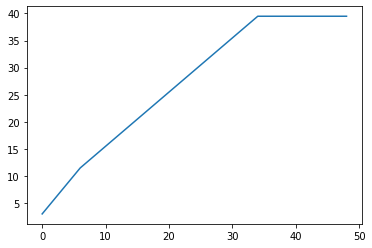

In [173]:
plt.plot(np.cumsum(svd(q_[0][1022]))) 

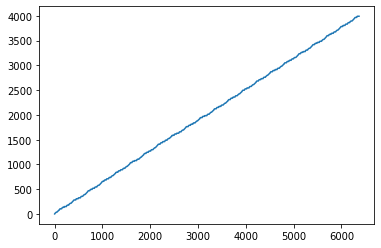

In [141]:
plt.plot(np.cumsum(svd(attn_op.detach().numpy())))

In [63]:
model.state_dict()['relative_position_bias_table']

KeyError: 'relative_position_bias_table'

In [64]:
relative_position_bias_table_keys = [k for k in model.state_dict().keys() if "relative_position_bias_table" in k]

In [65]:
relative_position_bias_table_keys

['layers.0.blocks.0.attn.relative_position_bias_table',
 'layers.0.blocks.1.attn.relative_position_bias_table',
 'layers.1.blocks.0.attn.relative_position_bias_table',
 'layers.1.blocks.1.attn.relative_position_bias_table',
 'layers.2.blocks.0.attn.relative_position_bias_table',
 'layers.2.blocks.1.attn.relative_position_bias_table',
 'layers.2.blocks.2.attn.relative_position_bias_table',
 'layers.2.blocks.3.attn.relative_position_bias_table',
 'layers.2.blocks.4.attn.relative_position_bias_table',
 'layers.2.blocks.5.attn.relative_position_bias_table',
 'layers.3.blocks.0.attn.relative_position_bias_table',
 'layers.3.blocks.1.attn.relative_position_bias_table']

In [30]:
x_windows = x_windows.view(-1, window_size * window_size, C)

In [31]:
x_windows.shape

torch.Size([10240, 49, 96])

In [32]:
x = x_windows
B_, N, C = x.shape
qkv_layer = torch.nn.Linear(C, C * 3, bias=True)

In [43]:
params = qkv_layer.named_parameters()
copy_params = [(m[1], m[0]) for m in qkv_layer.named_parameters()]
print(qkv_layer.state_dict()['weight'].shape)

torch.Size([288, 96])


In [33]:
layers_0_blocks_0_attn_qkv_weight = model.state_dict()['layers.0.blocks.0.attn.qkv.weight']

In [44]:
def get_model_weight(weight_name):
    return model.state_dict()[weight_name]

In [46]:
import copy

new_sd = copy.deepcopy(qkv_layer.state_dict())
new_sd['weight'] = get_model_weight('layers.0.blocks.0.attn.qkv.weight')
new_sd['bias'] = get_model_weight('layers.0.blocks.0.attn.qkv.bias')
qkv_layer.load_state_dict(new_sd)

<All keys matched successfully>

In [47]:
relative_position_bias_table = torch.nn.Parameter(
            torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

In [50]:
relative_position_bias_table.state_dict()

AttributeError: 'Parameter' object has no attribute 'state_dict'

In [34]:
layers_0_blocks_0_attn_qkv_weight.shape

torch.Size([288, 96])

In [ ]:
qkv =qkv_layer(x).reshape(B_, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)

In [24]:
x_windows.shape

torch.Size([10240, 49, 96])

In [10]:
layers_0_blocks_1_attn_qkv_weight.size()


torch.Size([288, 96])

In [15]:
m = np.random.rand(1,96)
m.shape

(1, 96)

In [15]:
m.shape

(1, 96)

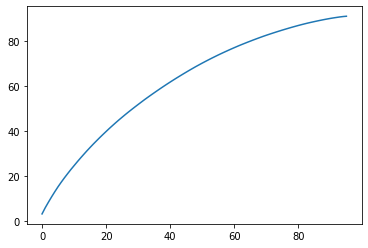

In [13]:
# plt.plot(svd(m))

plt.plot(np.cumsum(svd(layers_0_blocks_1_attn_qkv_weight.numpy())))
# plt.show()

In [23]:
(m.T).size()

TypeError: 'int' object is not callable

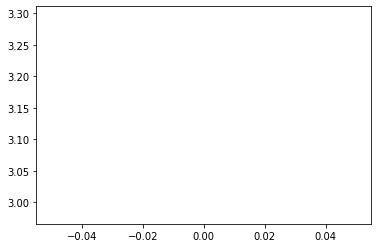

In [16]:
plt.plot(np.cumsum(svd(layers_0_blocks_1_attn_qkv_weight.numpy() @ m.T)))